In [ ]:
import numpy as np
import pandas as pd

class LogisticRegressionSGD:
    def __init__(self):
        self.w = 0.0
        self.b = 0.0
        self.loss_history = []

    def sigmoid(self, z):
        return 1 / (1 + np.exp(-z))

    def compute_loss(self, y, y_hat):
        y_hat = np.clip(y_hat, 1e-15, 1 - 1e-15)
        return -np.mean(y * np.log(y_hat) + (1 - y) * np.log(1 - y_hat))

    def compute_gradient(self, X, y):
        m = len(y)
        y_hat = self.sigmoid(np.dot(X, self.w) + self.b)
        error = y_hat - y
        gradient_w = np.dot(X.T, error) / m
        gradient_b = np.sum(error) / m
        return gradient_w, gradient_b

    def train(self, X, y, alpha=0.01, num_rounds=1000):
        if isinstance(X, pd.DataFrame):
            X = X.values
        if isinstance(y, pd.DataFrame):
            y = y.values.flatten()

        n = X.shape[1]
        self.w = np.zeros(n)

        for _ in range(num_rounds):
            gradient_w, gradient_b = self.compute_gradient(X, y)
            self.w -= alpha * gradient_w
            self.b -= alpha * gradient_b
            y_hat = self.predict_proba(X)
            self.loss_history.append(self.compute_loss(y, y_hat))

        return self
    
    def predict_proba(self, X):
        return self.sigmoid(np.dot(X, self.w) + self.b)

    def predict(self, X):
        return np.array([int(p >= 0.5) for p in self.predict_proba(X)])

In [151]:
from sklearn.model_selection import train_test_split

df = pd.read_csv("../data/features.csv")
df_train, df_test = train_test_split(df, test_size=0.2, stratify=df[["Gender", "France", "Germany", "Spain"]], random_state=42)

X_train = df_train.drop(["CustomerId", "Exited"], axis=1)
y_train = df_train["Exited"]
X_test = df_test.drop(["CustomerId", "Exited"], axis=1)
y_test = df_test["Exited"]

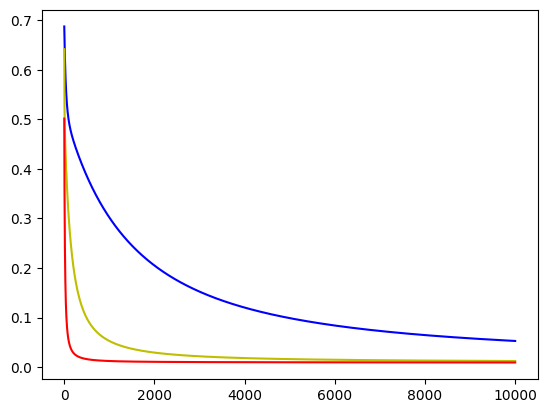

In [152]:
import matplotlib.pyplot as plt
%matplotlib inline

alphas = [0.01, 0.1, 1]
loss_log = {}
for alpha in alphas:
    lrsgd = LogisticRegressionSGD()
    lrsgd_model = lrsgd.train(X_train, y_train, alpha, 10000)
    loss_log[alpha] = lrsgd_model.loss_history

plt.plot(loss_log[0.01], "b")
plt.plot(loss_log[0.1], "y")
plt.plot(loss_log[1], "r")

In [153]:
from sklearn.metrics import f1_score

lrsgd = LogisticRegressionSGD()
lrsgd_model = lrsgd.train(X_train, y_train, 0.1, 10000)
y_hat = lrsgd_model.predict(X_test)
f1_score(y_test, y_hat)

0.9987261146496815